# AI Explainability

In this session, we will work on extracting insights from black box models and explaining how the model makes decisions.

- What features in the data did the model think are most important?
- For any single prediction from a model, how did each feature in the data affect that particular prediction?
- How does each feature affect the model's predictions in a big-picture sense (what is its typical effect when considered over a large number of possible predictions)? 

([Source](https://www.kaggle.com/code/dansbecker/use-cases-for-model-insights))





**Why Are These Insights Valuable?**

- Debugging
- Informing feature engineering
- Directing future data collection
- Informing human decision-making
- Building Trust

#### Two types of interpretation:

- **Global Interpretation:** inspect model parameters and try to figure out how the model works globally. 

- **Local Interpretation:** inspect an individual prediction of a model, try to figure out why the model makes the decision it makes.


### Import Libraries

! pip install eli5


! pip install pdpbox

! pip install shap


In [21]:
#! pip install eli5 

#! pip install pdpbox

#! pip install shap 

import numpy as np
import pandas as pd
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance

from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots


## 1- Permutation Importance & ELI5 ( Explain like I’m 5) 

**What features have the biggest impact on predictions?**

- For Global Interpretation ELI5 provides *eli5.show_weights()* function;

    for Local Interpretation it provides *eli5.show_prediction()* function. 


- For white-box models (Linear Regression , Decision Trees ) it supports both Global & Local Interpretation , 

    for black-box (Keras , XGBoost , LightGBM)  models it supports only Global Interpretation.

**How it works?**


1. Get a trained model.
2. Shuffle the values in a single column, make predictions using the resulting dataset. Use these predictions and the true target values to calculate how much the loss function suffered from shuffling. That performance deterioration measures the importance of the variable you just shuffled.
3. Return the data to the original order (undoing the shuffle from step 2). Now repeat step 2 with the next column in the dataset, until you have calculated the importance of each column.


In [22]:
data = pd.read_csv('/content/FIFA 2018 Statistics.csv')
data.shape

(128, 27)

In [23]:
data.head(3)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN


In [24]:
data['Man of the Match'].value_counts()

Yes    64
No     64
Name: Man of the Match, dtype: int64

In [25]:
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(n_estimators=100,
                                  random_state=0).fit(train_X, train_y)

In [26]:
perm = PermutationImportance(my_model, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.1750 ± 0.0848,Goal Scored
0.0500 ± 0.0637,Distance Covered (Kms)
0.0437 ± 0.0637,Yellow Card
0.0187 ± 0.0500,Off-Target
0.0187 ± 0.0637,Free Kicks
0.0187 ± 0.0637,Fouls Committed
0.0125 ± 0.0637,Pass Accuracy %
0.0125 ± 0.0306,Blocked
0.0063 ± 0.0612,Saves
0.0063 ± 0.0250,Ball Possession %


#### Alternative: Column Drop Importance 

More accurate but expensive. Because every time;

1-  We temporarily remove 1 column and re-fit model. 

2- We compute val set performance and compare.

## 2 - Partial Dependence Plots


While feature importance shows what variables *MOST* affect predictions, partial dependence plots show *HOW* a feature affects predictions.

This is useful to answer questions like:

- How would similarly sized houses be priced in different areas?

- Are predicted health differences between two groups due to differences in their diets, or due to some other factor?


In [27]:
data['Distance Covered (Kms)'].describe()

count    128.000000
mean     106.664062
std       11.749537
min       80.000000
25%      101.000000
50%      104.500000
75%      109.000000
max      148.000000
Name: Distance Covered (Kms), dtype: float64

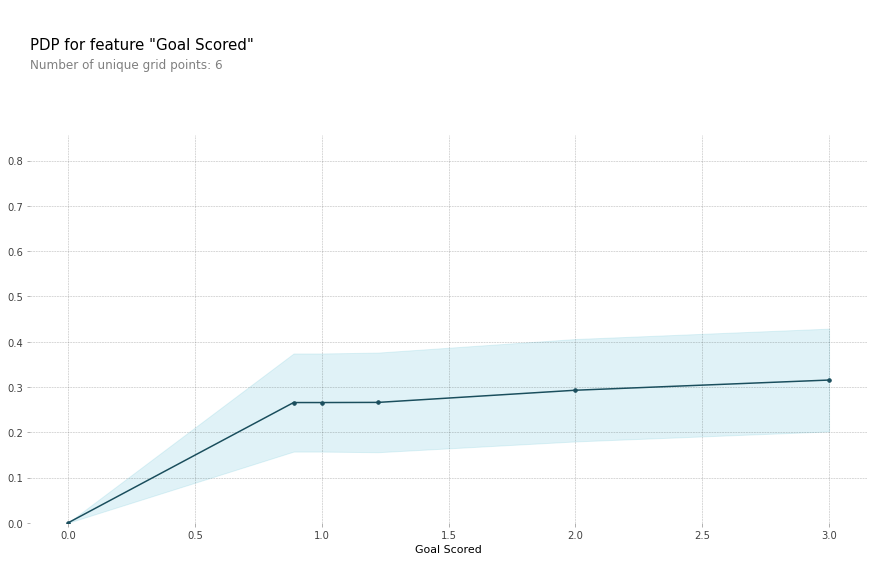

In [39]:
feature_to_plot = 'Goal Scored'
pdp_dist = pdp.pdp_isolate(model=my_model, dataset=val_X, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

## 3 - SHAP - SHapley Additive exPlanations

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

Where could you use this?

- Example: A model says a bank shouldn't loan someone money, and the bank is legally required to explain the basis for each loan rejection
- Example: A healthcare provider wants to identify what factors are driving each patient's risk of some disease so they can directly address those risk factors with targeted health interventions


*sum(SHAP values for all features) = pred_for_team - pred_for_baseline_values*

That is, the SHAP values of all features sum up to explain why my prediction was different from the baseline.


In [40]:
row_to_show = 6
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

In [30]:
import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_value = explainer.shap_values(data_for_prediction)


**Global Feature Importances**

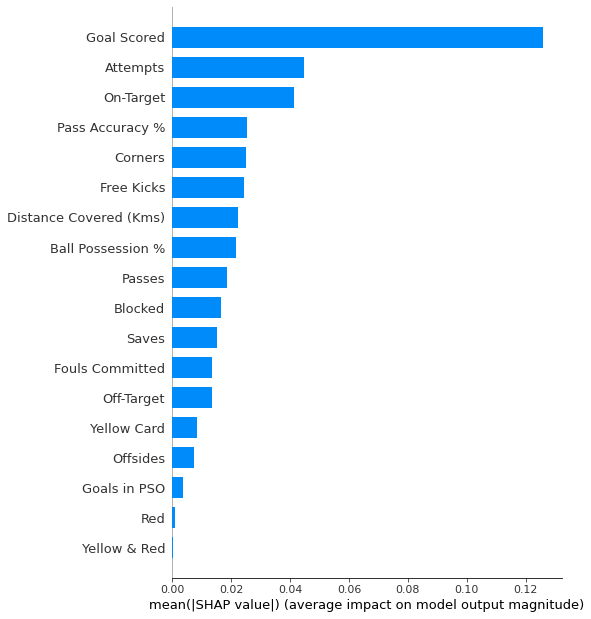

In [31]:
shap.summary_plot(
    shap_values[1], val_X, feature_names=val_X.columns, plot_type="bar"
)

**Summary Plot**


SHAP summary plots give us a birds-eye view of feature importance and what is driving it.

This plot is made of many dots. Each dot has three characteristics:

- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

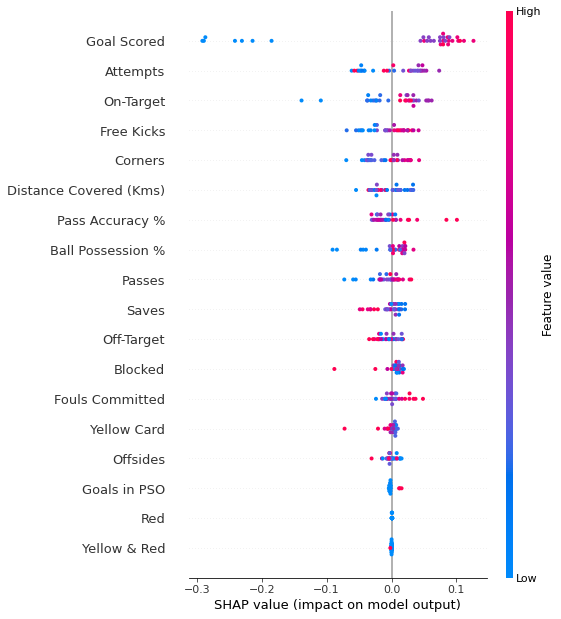

In [32]:
# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X)

**Dependence Contribution Plots**

SHAP dependence contribution plots provide a similar insight to PDP's, but they add a lot more detail.

For instance, what is the distribution of effects? Is the effect of having a certain value pretty constant, or does it vary a lot depending on the values of other feaures. 

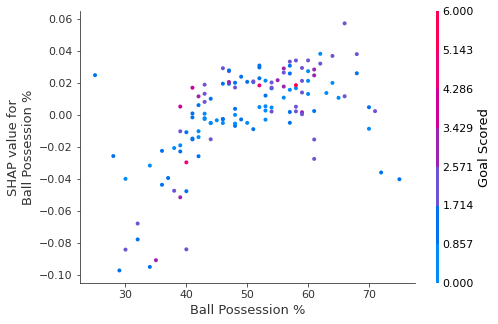

In [33]:
# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X)

# make plot.
shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

**Individual prediction**


In [34]:
data_for_prediction

Goal Scored                 2
Ball Possession %          54
Attempts                   22
On-Target                   7
Off-Target                 11
Blocked                     4
Corners                     8
Offsides                    1
Free Kicks                 17
Saves                       0
Pass Accuracy %            79
Passes                    622
Distance Covered (Kms)    143
Fouls Committed            23
Yellow Card                 2
Yellow & Red                0
Red                         0
Goals in PSO                0
Name: 122, dtype: int64

In [35]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_value[1], data_for_prediction) 